In [1]:
!pip install geopandas==0.8.2
!pip install osmnx==1.0.1

# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [2]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

## Working with street networks

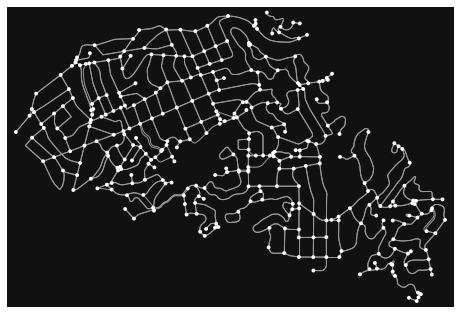

In [3]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive')
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

In [4]:
# convert your MultiDiGraph to an undirected MultiGraph
M = ox.get_undirected(G)

# convert your MultiDiGraph to a DiGraph without parallel edges
D = ox.get_digraph(G)

In [5]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
53017091,37.826250,-122.247604,3,NaN,POINT (-122.24760 37.82625)
53018397,37.824204,-122.247163,3,NaN,POINT (-122.24716 37.82420)
53018399,37.824911,-122.246072,3,NaN,POINT (-122.24607 37.82491)
53018402,37.825406,-122.245317,3,NaN,POINT (-122.24532 37.82541)
53018404,37.825948,-122.244467,3,NaN,POINT (-122.24447 37.82595)


In [6]:
gdf_edges.head()

osmid          name      highway  oneway   length  \
u        v        key                                                          
53017091 53064327 0      6345781   Rose Avenue  residential   False  231.335   
         53075599 0      6345781   Rose Avenue  residential   False  121.114   
53018397 53097980 0    196739937  Linda Avenue     tertiary   False  104.138   
         53018399 0      6327298   Lake Avenue  residential   False  123.939   
         53018411 0    196739937  Linda Avenue     tertiary   False   35.185   

                                                                geometry  \
u        v        key                                                      
53017091 53064327 0    LINESTRING (-122.24760 37.82625, -122.24551 37...   
         53075599 0    LINESTRING (-122.24760 37.82625, -122.24770 37...   
53018397 53097980 0    LINESTRING (-122.24716 37.82420, -122.24777 37...   
         53018399 0    LINESTRING (-122.24716 37.82420, -122.24709 37...   
         53018411 0    LINESTRING (-122.24716 37.82420, -122.24712 37...   

                      lanes maxspeed bridge junction  
u        v        key                                 
53017091 53064327 0     NaN      NaN    NaN      NaN  
         53075599 0     NaN      NaN    NaN      NaN  
53018397 53097980 0     NaN      NaN    NaN      NaN  
         53018399 0     NaN      NaN    NaN      NaN  
         53018411 0     NaN      NaN    NaN      NaN

You can create a graph from node/edge GeoDataFrames, as long as gdf_nodes is indexed by osmid and gdf_edges is multi-indexed by u, v, key (following normal MultiDiGraph structure). This allows you to load graph node/edge shapefiles or GeoPackage layers as GeoDataFrames then convert to a MultiDiGraph for graph analytics.

In [7]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

## Basic street network stats

In [8]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

4215167.729117582

In [9]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 342,
 'm': 926,
 'k_avg': 5.415204678362573,
 'intersection_count': 309,
 'streets_per_node_avg': 2.9590643274853803,
 'streets_per_node_counts': {0: 0, 1: 33, 2: 0, 3: 260, 4: 47, 5: 1, 6: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.09649122807017543,
  2: 0.0,
  3: 0.7602339181286549,
  4: 0.13742690058479531,
  5: 0.0029239766081871343,
  6: 0.0029239766081871343},
 'edge_length_total': 113191.60299999993,
 'edge_length_avg': 122.2371522678185,
 'street_length_total': 58445.19200000005,
 'street_length_avg': 121.25558506224075,
 'street_segments_count': 482,
 'node_density_km': 81.13556137695984,
 'intersection_density_km': 73.30669141953389,
 'edge_density_km': 26853.404247260136,
 'street_density_km': 13865.448721357328,
 'circuity_avg': 1.1135285047574028,
 'self_loop_proportion': 0.0064794816414686825,
 'clean_intersection_count': 269,
 'clean_intersection_density_km': 63.81715207719941}

stats documentation: https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats

In [10]:
# see more stats (mostly topological stuff) with extended_stats
more_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True) #use arguments to turn other toplogical analyses on/off
for key in sorted(more_stats.keys()):
    print(key)

avg_neighbor_degree
avg_neighbor_degree_avg
avg_weighted_neighbor_degree
avg_weighted_neighbor_degree_avg
betweenness_centrality
betweenness_centrality_avg
center
closeness_centrality
closeness_centrality_avg
clustering_coefficient
clustering_coefficient_avg
clustering_coefficient_weighted
clustering_coefficient_weighted_avg
degree_centrality
degree_centrality_avg
diameter
eccentricity
pagerank
pagerank_max
pagerank_max_node
pagerank_min
pagerank_min_node
periphery
radius


In [11]:
more_stats['radius']

2507.464

The radius (i.e., minimum eccentricity) of this street network is approximately 2.5 kilometers.

In [12]:
# save graph to disk as geopackage (for GIS) or graphml file (for gephi etc)
ox.save_graph_geopackage(G, filepath='./data/mynetwork.gpkg')
ox.save_graphml(G, filepath='./data/mynetwork.graphml')

## Visualize street centrality

Here we plot the street network and color its edges (streets) by their relative closeness centrality.

In [13]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

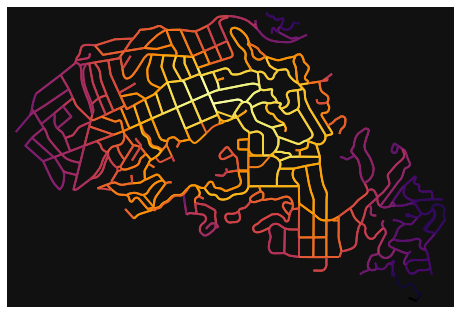

In [14]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

## Routing

In [15]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [16]:
# get the nearest network nodes to two lat/lng points
orig = ox.get_nearest_node(G, (37.828903, -122.245846))
dest = ox.get_nearest_node(G, (37.812303, -122.215006))

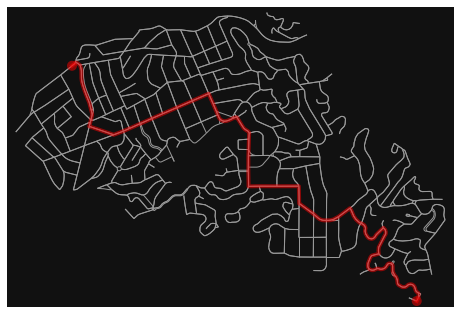

In [17]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [18]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
sum(edge_lengths)

4789.3460000000005

In [19]:
# how far is it between these two nodes as the crow flies (haversine)?
ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])

3123.7985450057035

In [20]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key
    G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
    G = ox.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color='#333')
except ImportError:
    pass

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

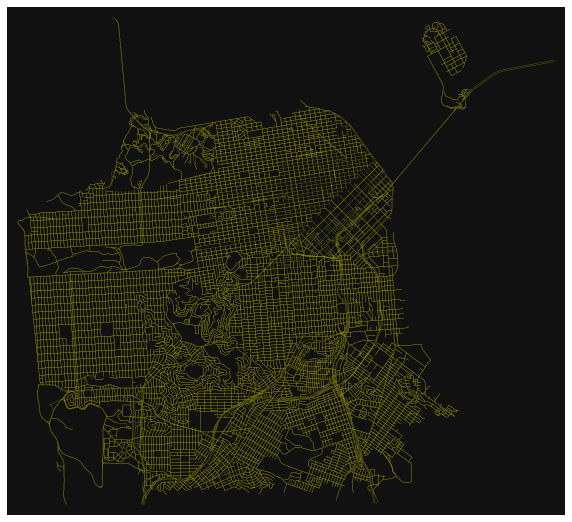

In [21]:
# you can make query an unambiguous dict to help the geocoder find it
place = {'city'   : 'San Francisco',
         'state'  : 'California',
         'country': 'USA'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

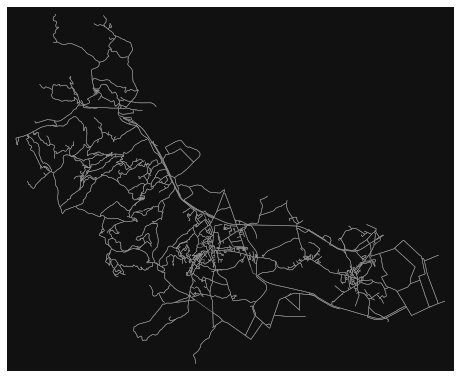

In [22]:
# you can get networks anywhere in the world
G = ox.graph_from_place('Sinalunga, Italy', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

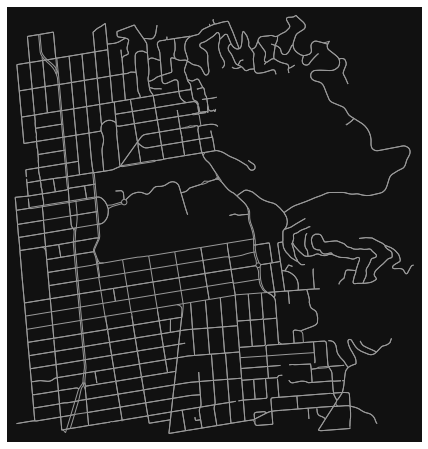

In [23]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609 #meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

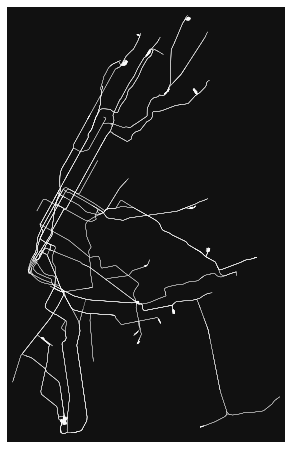

In [24]:
# get NY subway rail network
G = ox.graph_from_place('New York City, New York',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)

## Get any geospatial entities' geometries and attributes

Use the `geometries` module to download entities, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries). For more usage examples of downloading geospatial objects from OSM, see [this notebook](16-download-osm-geospatial-entities.ipynb).

In [25]:
# get all building footprints in some neighborhood
place = 'Bunker Hill, Los Angeles, California'
tags = {'building': True}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(52, 45)

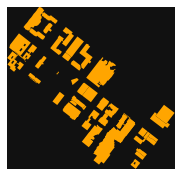

In [26]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [27]:
# get all parks and bus stops in some neighborhood
tags = {'leisure': 'park',
        'highway': 'bus_stop'}
gdf = ox.geometries_from_place(place, tags)
gdf.shape

(20, 21)